In [1]:
import os
import re
import numpy as np
import numpy
genecode_genes = set(os.listdir("experiment_blood"))
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt
import random
import bisect
import math
import json
%matplotlib inline

In [2]:
def load_genes(filename):
    genes = set()
    repeated = set()
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if line in genes:
                repeated.add(line)
            genes.add(line)
    failed = genes.difference(genecode_genes)
    if repeated:
        print("These genes appear more than once: {}".format([g for g in repeated]))
    if failed:
        print("Couldn't identify the following genes: {}".format([g for g in failed]))
    return genes.intersection(genecode_genes)

In [3]:
nakamori_genes = load_genes("nakamori_genes.txt")

These genes appear more than once: ['LDB3', 'DMD']
Couldn't identify the following genes: ['OHKA1', 'OPA']


In [4]:
# Genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4224598/
batra_genes = load_genes("batra_genes.txt")

These genes appear more than once: ['IDH3A', 'PDLIM5', 'CEBPA', 'TPM2', 'MEF2B', 'TPM3', 'PCM1', 'TTYH3', 'ASPH', 'DNAJB6', 'TPM1', 'NDUFB10', 'LDB3', 'CHRNA1', 'SNX1', 'TNNI1', 'MST150']
Couldn't identify the following genes: ['SR140', 'DNAPTP6', 'CUGBP1', 'MST150', 'ADFP']


In [5]:
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

In [6]:
blood_meta, muscle_meta = load_metadata()

In [7]:
def produce_data(meta, gene_names, experiment):
    IDs = meta.IDs
    probe_data = []
    probe_IDs = []
    for gene in gene_names:
        with open(os.path.join(experiment, gene)) as f:
            for i, line in enumerate(f):
                line = line.rstrip().split()
                if i == 0:
                    prefix = "patient_"
                    our_IDs = [elem[len(prefix):] for elem in line if re.match(prefix, elem)]
                    assert IDs == our_IDs
                    headers = {header: i for i, header in enumerate(line)}
                    patient_data = {header[len(prefix):]: i for i, header in enumerate(line) if re.match(prefix, header)}
                    def write_signature(line):
                        signature = []
                        for elem in ["gene_name", "probeset_id", "seq5to3plus", "chrom", "strand", "genocode_left", "genecode_right"]:
                            signature.append(line[headers[elem]])
                        return "_".join(signature)
                else:
                    probe_ID = write_signature(line)
                    rv = []
                    for patient_id in IDs:
                        rv.append(float(line[patient_data[patient_id]]))
                    probe_data.append(rv)
                    probe_IDs.append(probe_ID)
    probe_data = numpy.array(probe_data)
    return probe_data, probe_IDs

In [8]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[just_indices, :]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[0]):
        gene_r, _ = pearsonr(allele, data[i])
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[1]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[:, training_indices], data[:, test_indices]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

In [9]:
def simulation_step(probeset_data, metadata, training_size, no_probes, n_components):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [i[0] for i in results]

    return repeat_length_testing, results

In [10]:
def simulation(data, metadata, runs, no_probes, n_components):
    sample_no, patient_no = data.shape
    real_alleles = []
    simulated_alleles = []
    for i in range(runs):
        real_allele, simulated_allele = simulation_step(data, metadata, patient_no//2, no_probes, n_components)
        real_alleles += real_allele
        simulated_alleles += simulated_allele
    plt.figure()
    plt.scatter(real_alleles, simulated_alleles)
    r, _ = pearsonr(real_alleles, simulated_alleles)
    r_squared = r**2

    r2s = []
    sim = 100000
    for i in range(sim):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(sim)
    print("r² is {}, which corrsponds to p-value {}".format(r_squared, p_value))
    return r_squared, p_value

In [11]:
nakamori_blood_data, nakamori_blood_annot = produce_data(blood_meta, nakamori_genes, "experiment_blood")
nakamori_muscle_data, nakamori_muscle_annot = produce_data(muscle_meta, nakamori_genes, "experiment_muscle")
batra_blood_data, batra_blood_annot = produce_data(blood_meta, batra_genes, "experiment_blood")
batra_muscle_data, batra_muscle_annot = produce_data(muscle_meta, batra_genes, "experiment_muscle")
TNNI1_muscle, batra_3_genes_muscle_annot = produce_data(muscle_meta, ["TNNI1"], "experiment_muscle")
TNNI1_blood, batra_3_genes_blood_annot = produce_data(blood_meta, ["TNNI1"], "experiment_blood")
all_muscle_data, all_muscle_annot = produce_data(muscle_meta, genecode_genes, "experiment_muscle")
all_blood_data, all_blood_annot = produce_data(blood_meta, genecode_genes, "experiment_blood")

r² is 0.348893383988, which corrsponds to p-value 0.00129


(0.34889338398789344, 0.0012900000000000134)

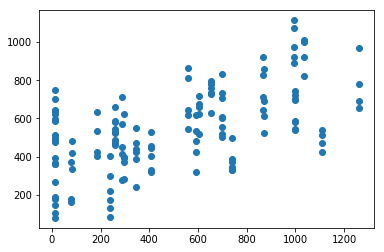

In [12]:
simulation(nakamori_muscle_data, muscle_meta, 10, 500, 5)

r² is 0.0120810457945, which corrsponds to p-value 0.52707


(0.012081045794462427, 0.5270699999999999)

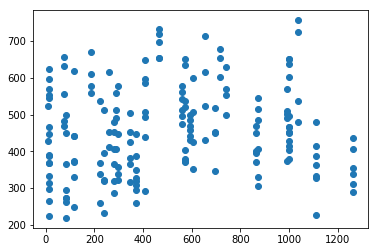

In [13]:
simulation(nakamori_blood_data, blood_meta, 10, 500, 5)

r² is 0.00836342965071, which corrsponds to p-value 0.64943


(0.0083634296507073737, 0.64943)

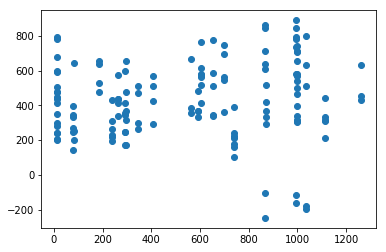

In [14]:
simulation(batra_muscle_data, muscle_meta, 10, 500, 5)

r² is 0.0522834695779, which corrsponds to p-value 0.18686


(0.052283469577886599, 0.18686000000000003)

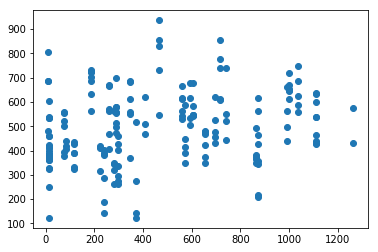

In [15]:
simulation(batra_blood_data, blood_meta, 10, 500, 5)

r² is 0.00640035928986, which corrsponds to p-value 0.64679


(0.0064003592898587191, 0.64679)

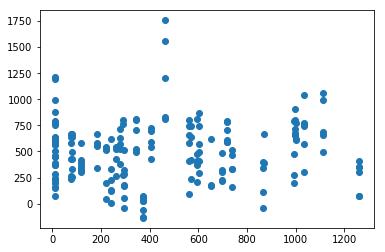

In [16]:
simulation(TNNI1_blood, blood_meta, 10, 500, 5)

r² is 0.0265312511554, which corrsponds to p-value 0.4143


(0.026531251155380329, 0.4143)

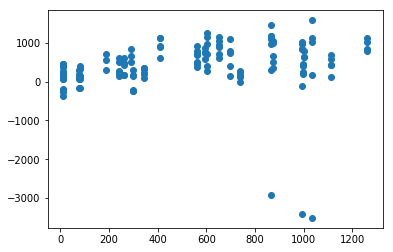

In [17]:
simulation(TNNI1_muscle, muscle_meta, 10, 500, 5)

r² is 0.135803893551, which corrsponds to p-value 0.0588


(0.13580389355105277, 0.05879999999999996)

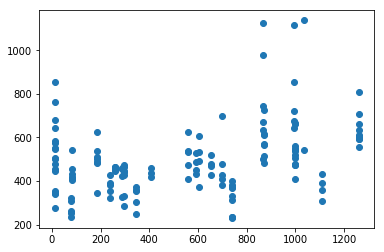

In [18]:
simulation(all_muscle_data, muscle_meta, 10, 500, 5)

r² is 0.0494356986002, which corrsponds to p-value 0.19704


(0.04943569860016498, 0.19704)

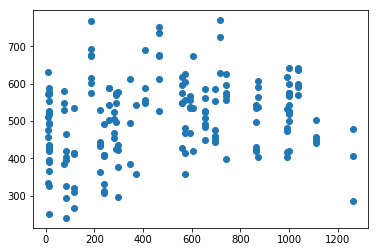

In [19]:
simulation(all_blood_data, blood_meta, 10, 500, 5)